
Archivo: Copilado1EEG.txt
MSE después del filtrado: 0.1419
SNR después del filtrado: 22.76 dB


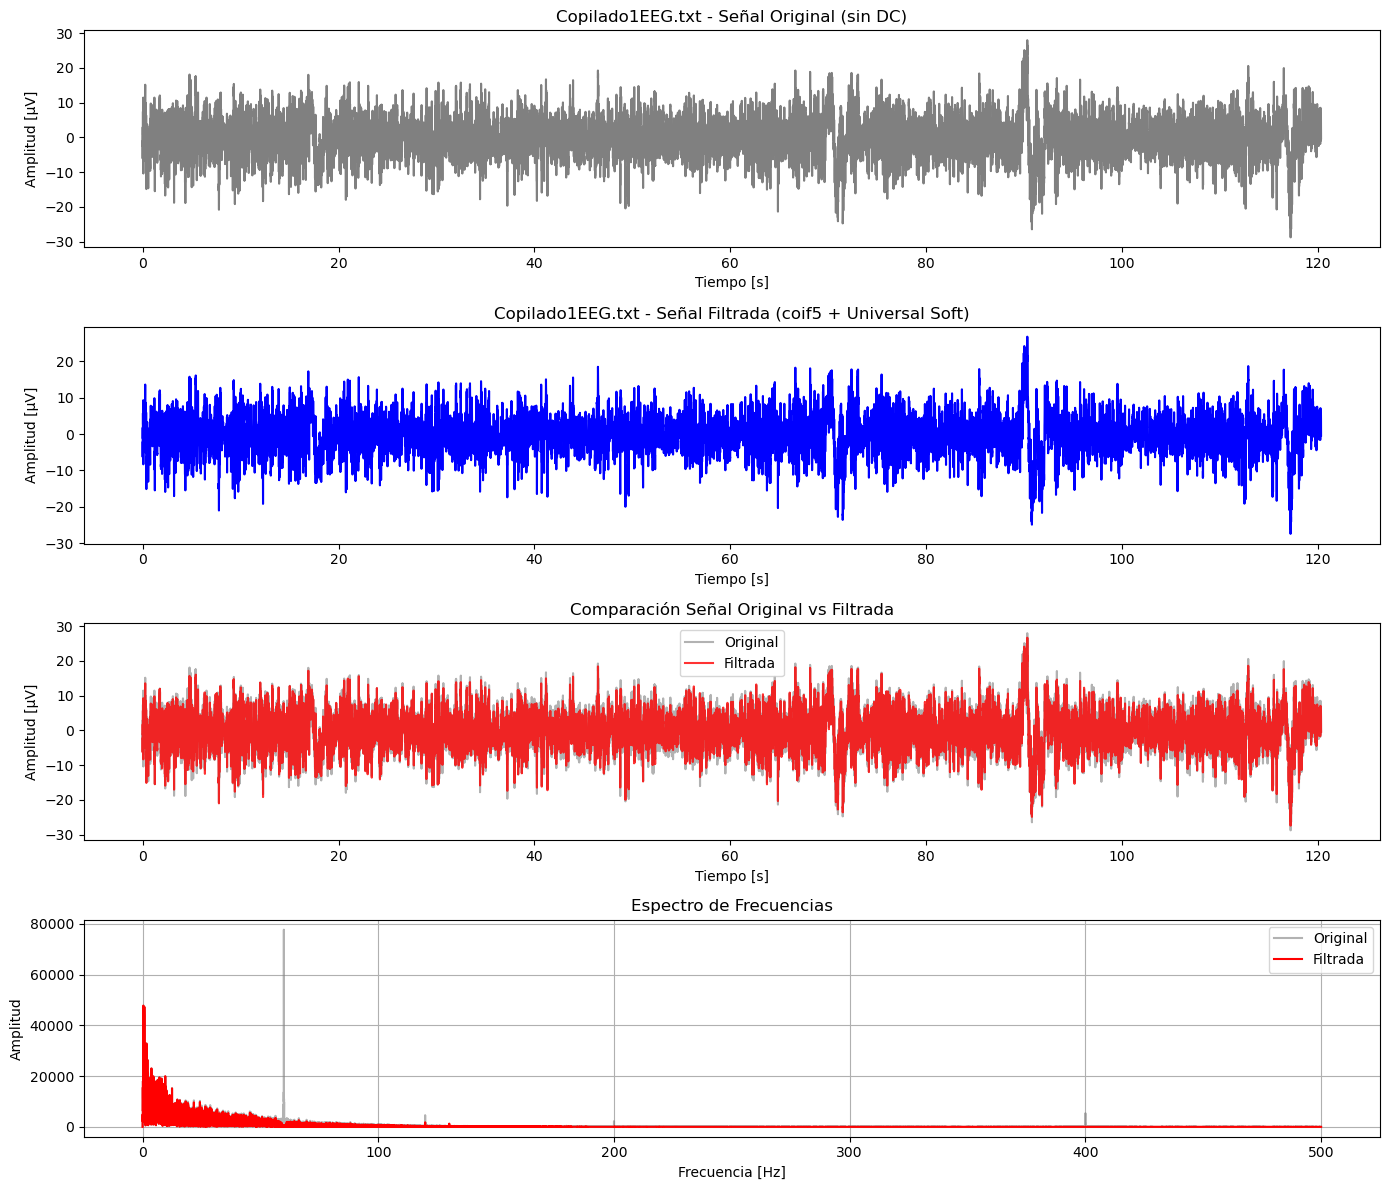

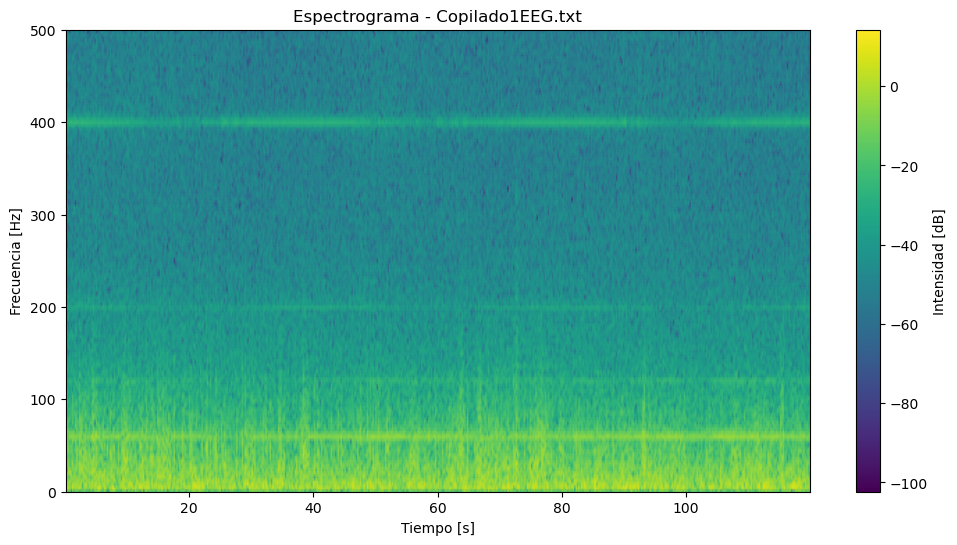

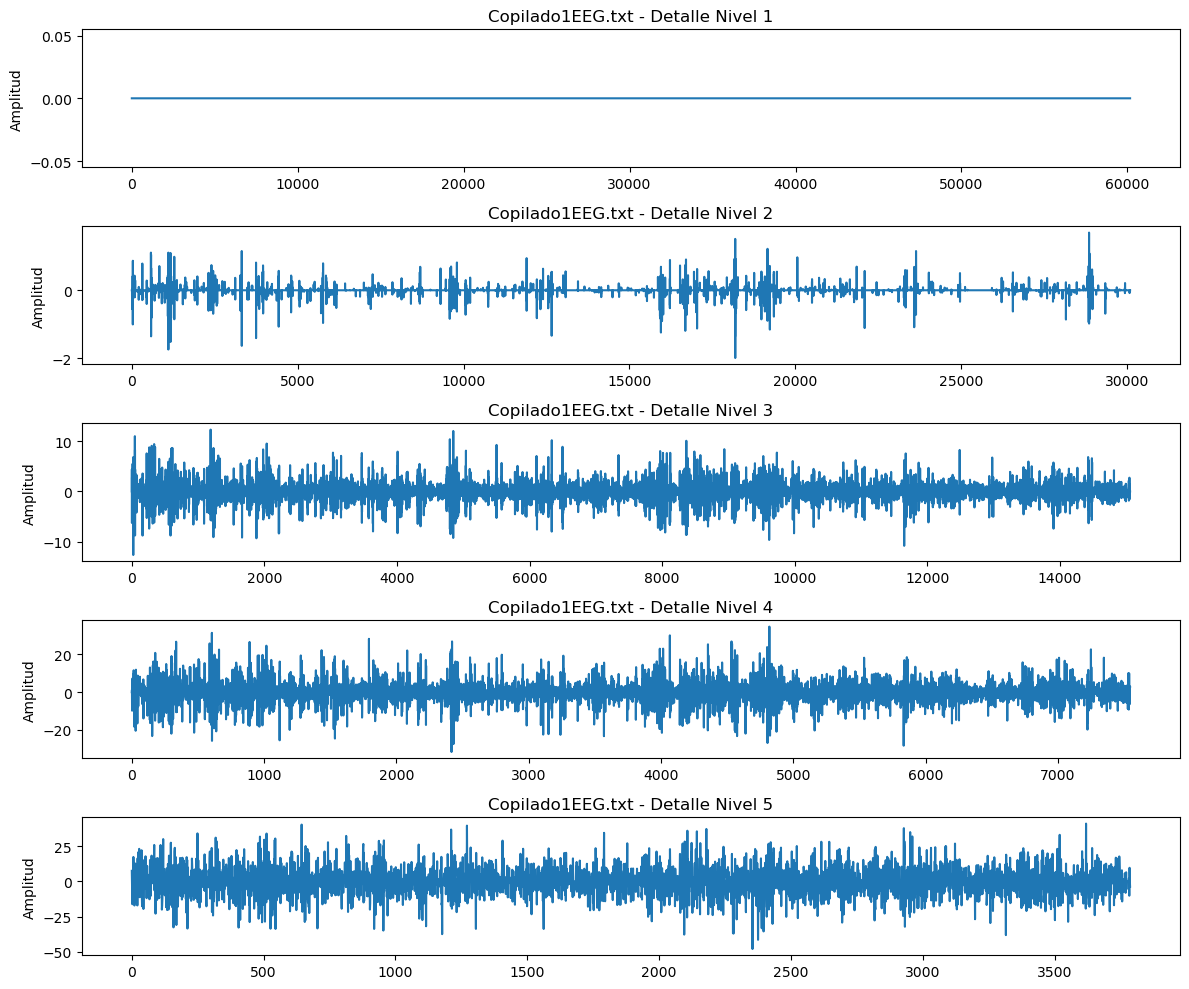


Archivo: RestaEEG.txt
MSE después del filtrado: 0.0930
SNR después del filtrado: 33.74 dB


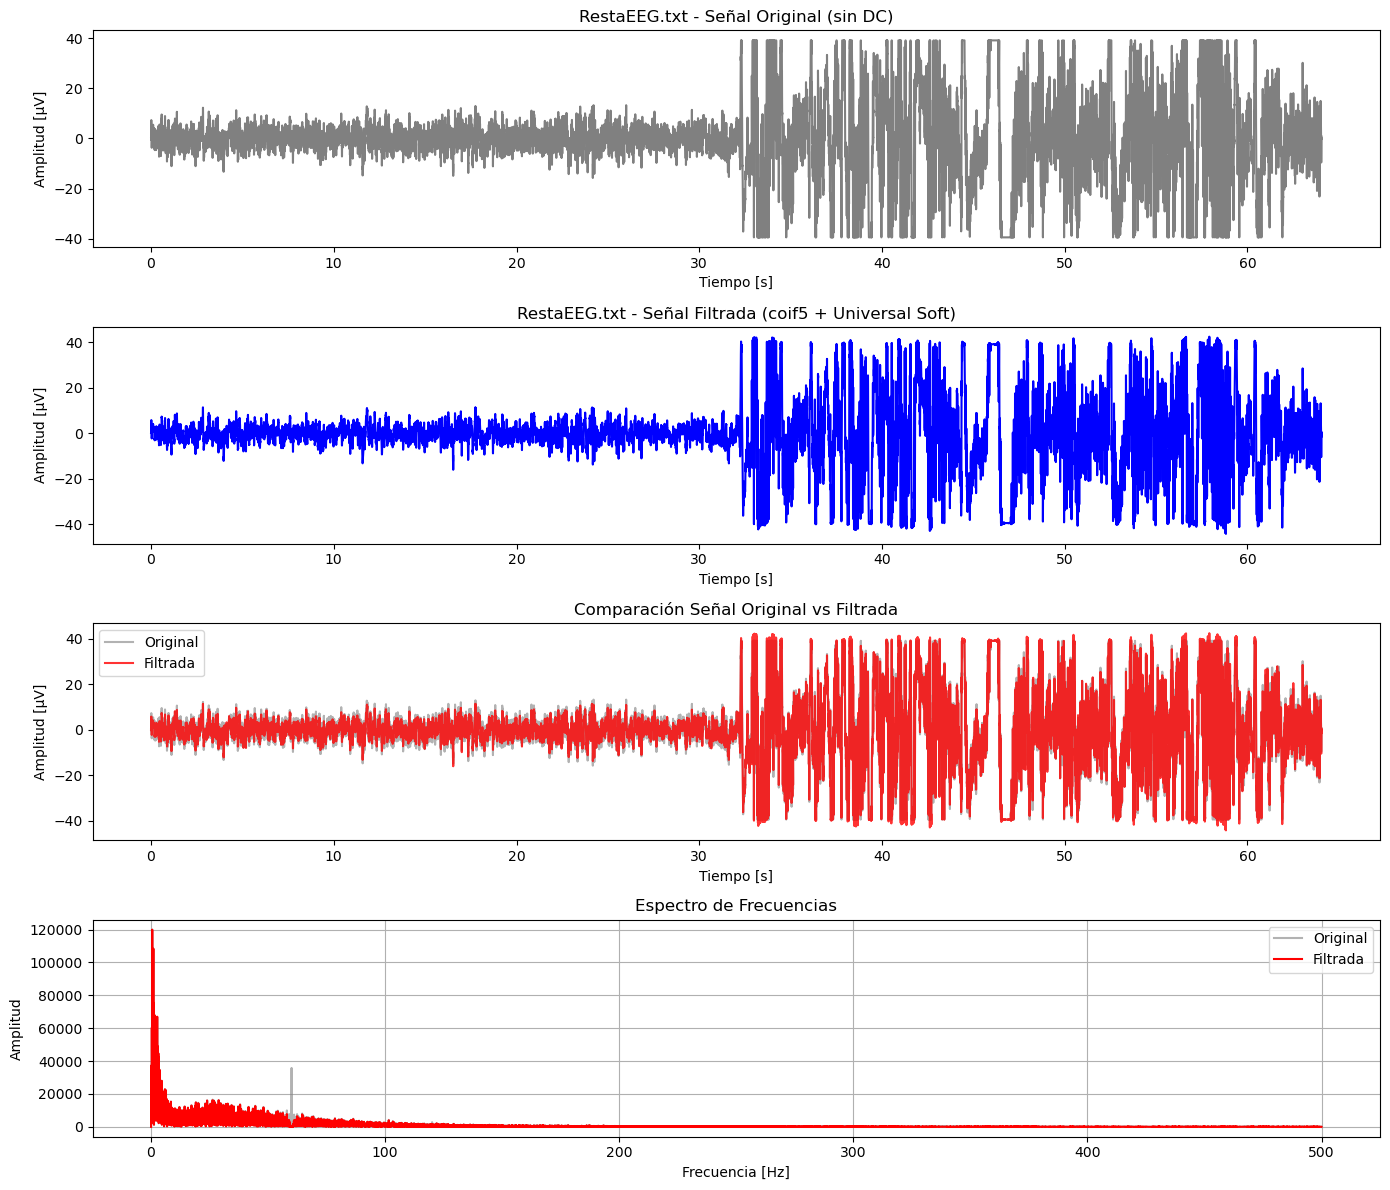

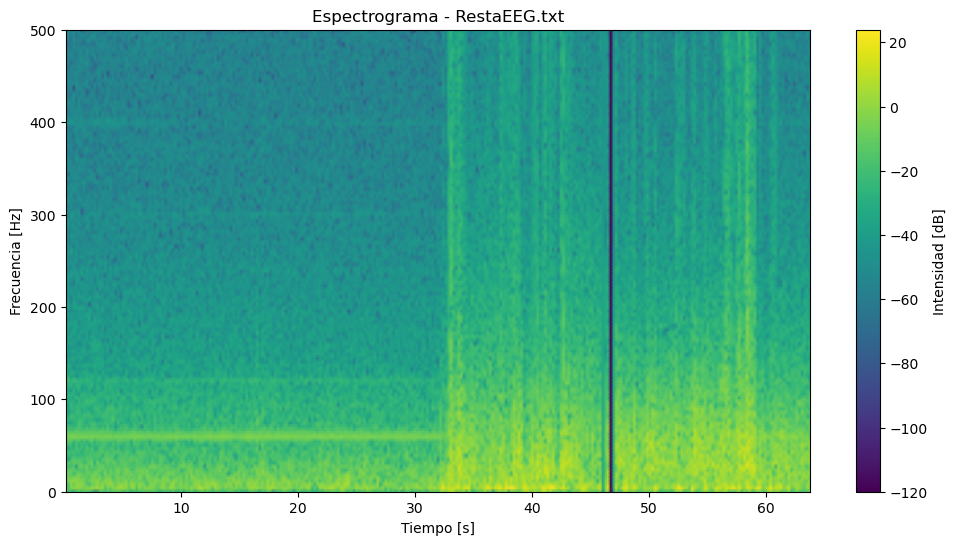

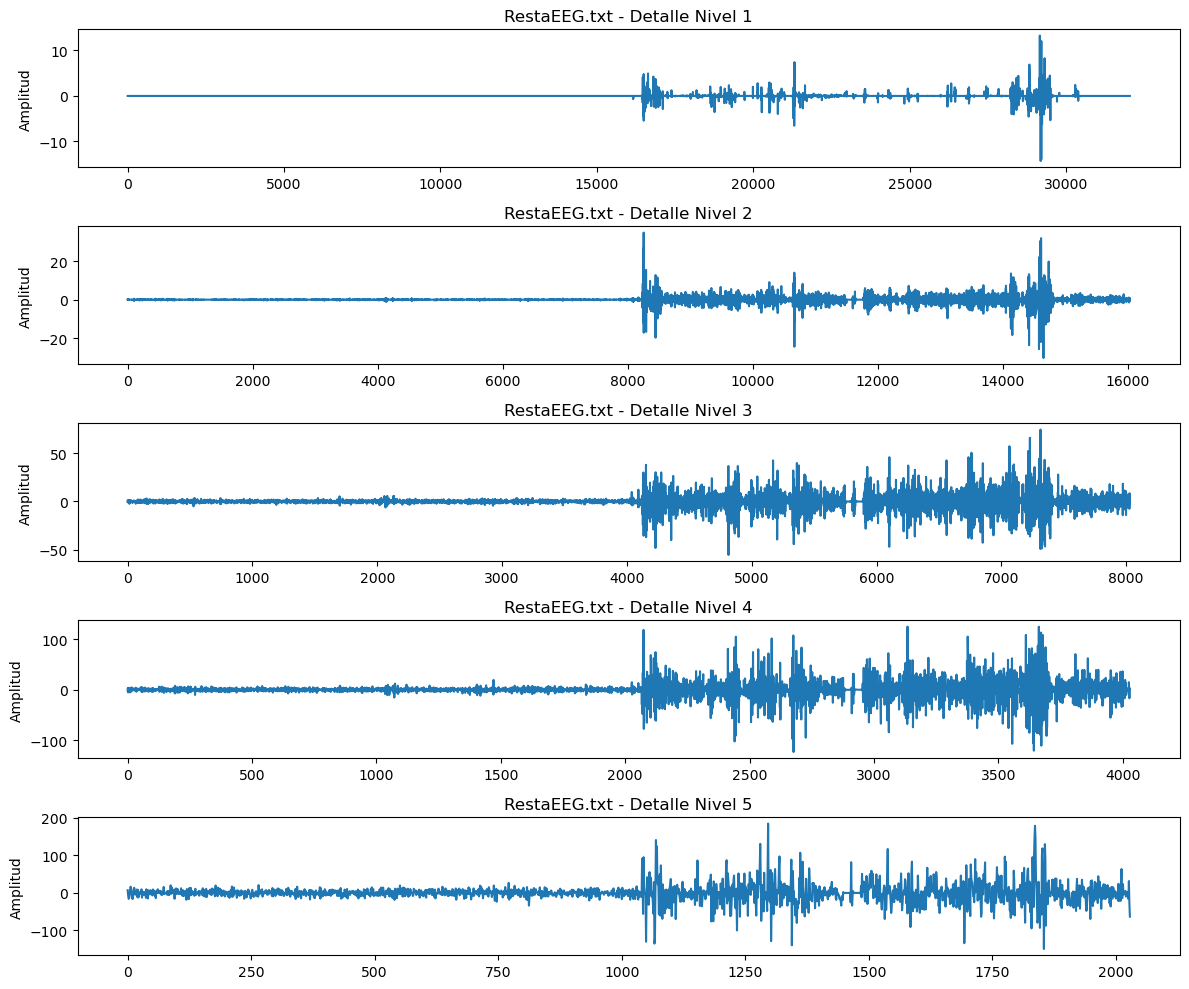


Archivo: Parpadeo2.txt
MSE después del filtrado: 0.1231
SNR después del filtrado: 32.20 dB


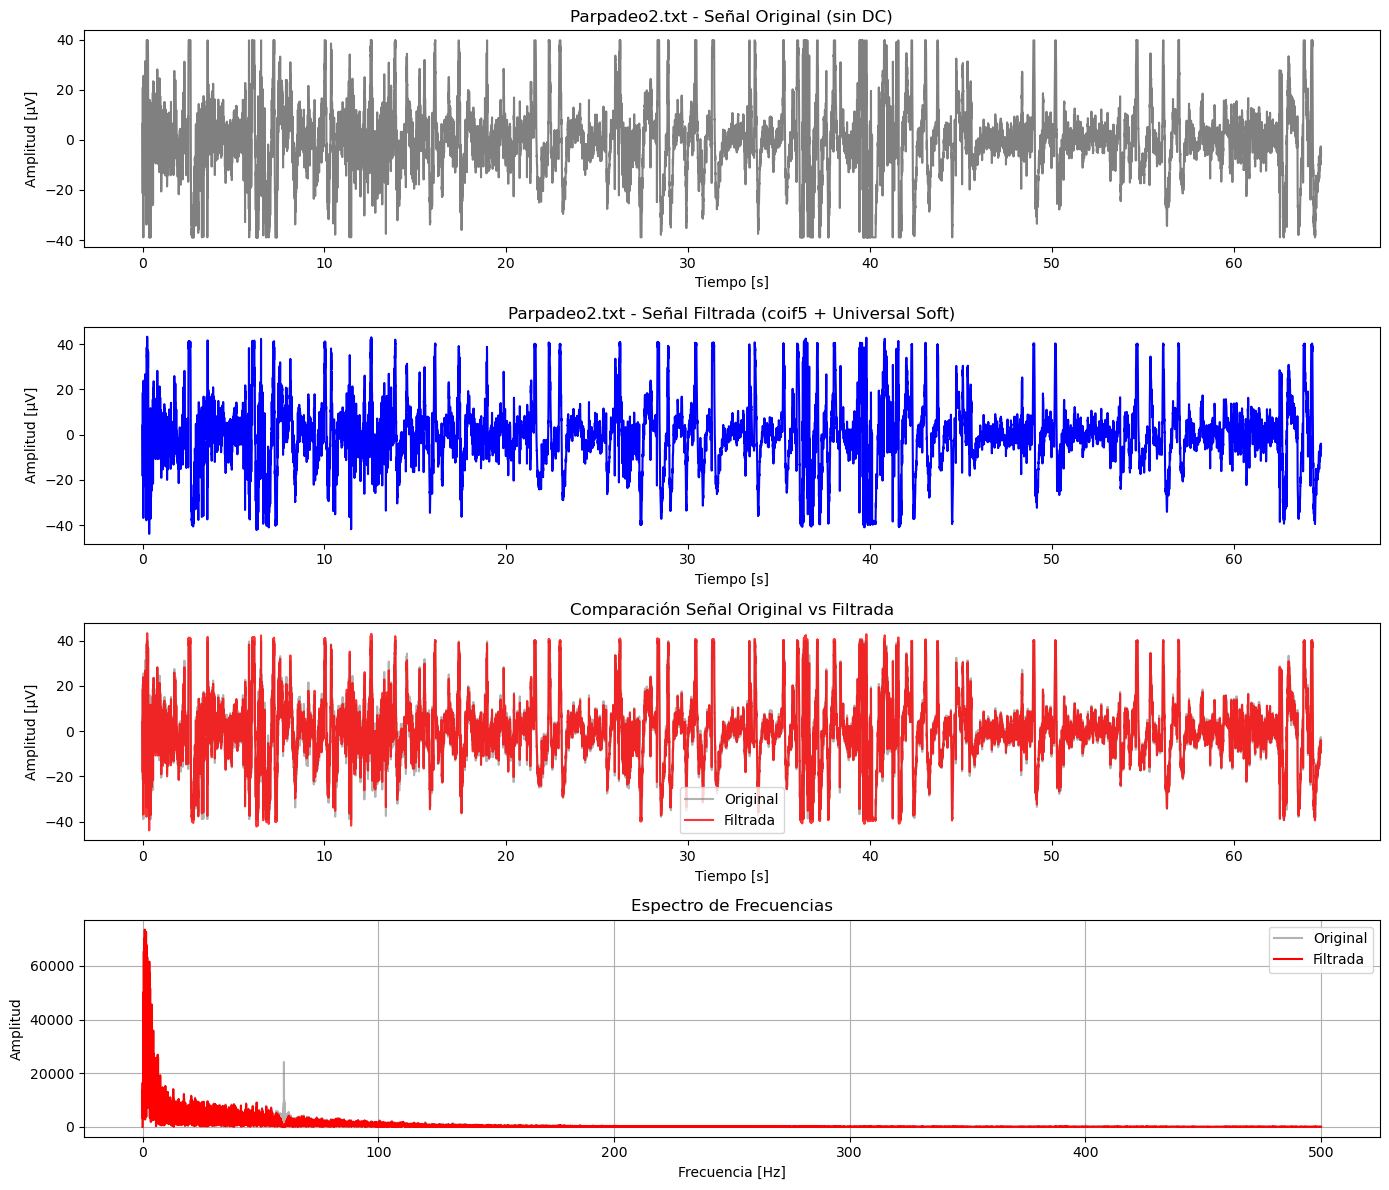

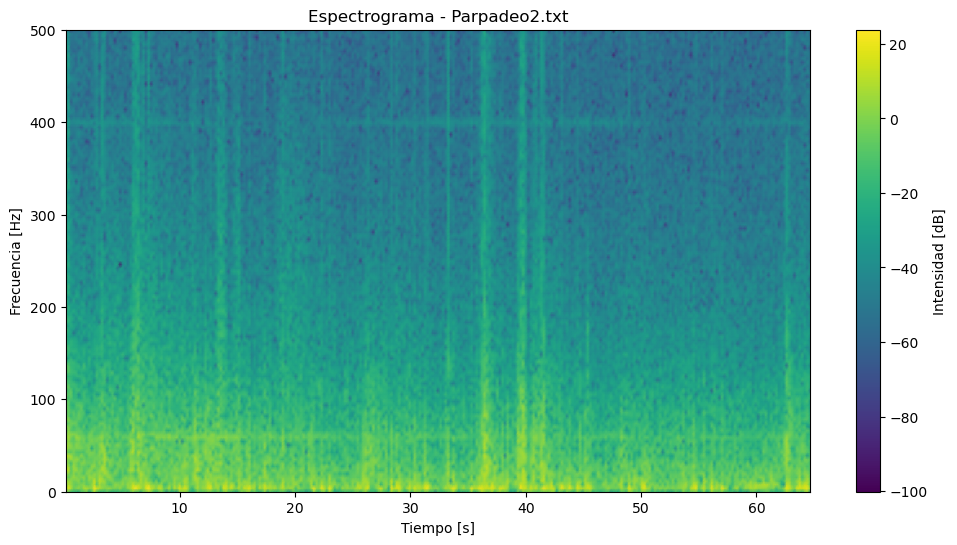

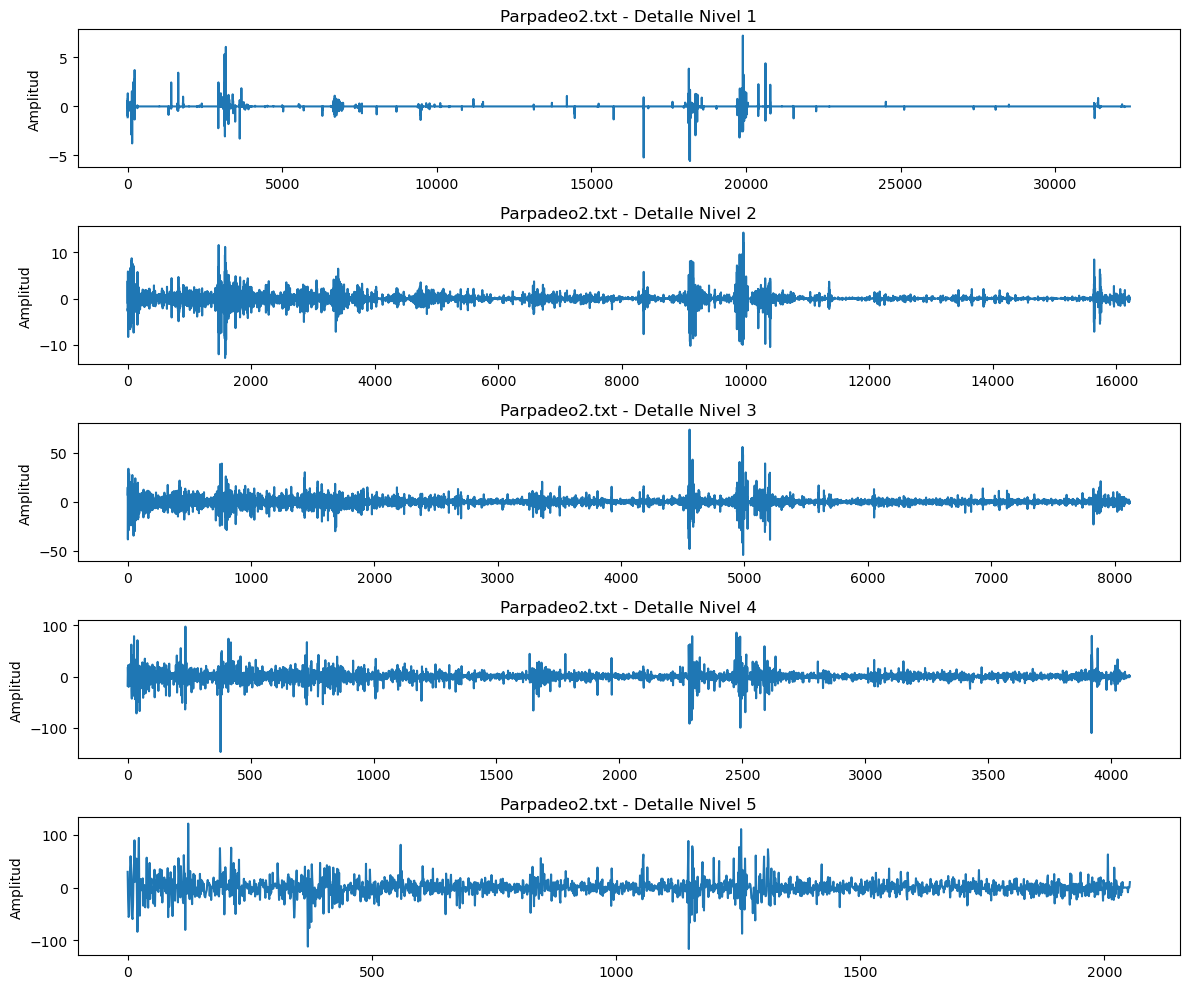


Archivo: musica.txt
MSE después del filtrado: 0.1157
SNR después del filtrado: 33.27 dB


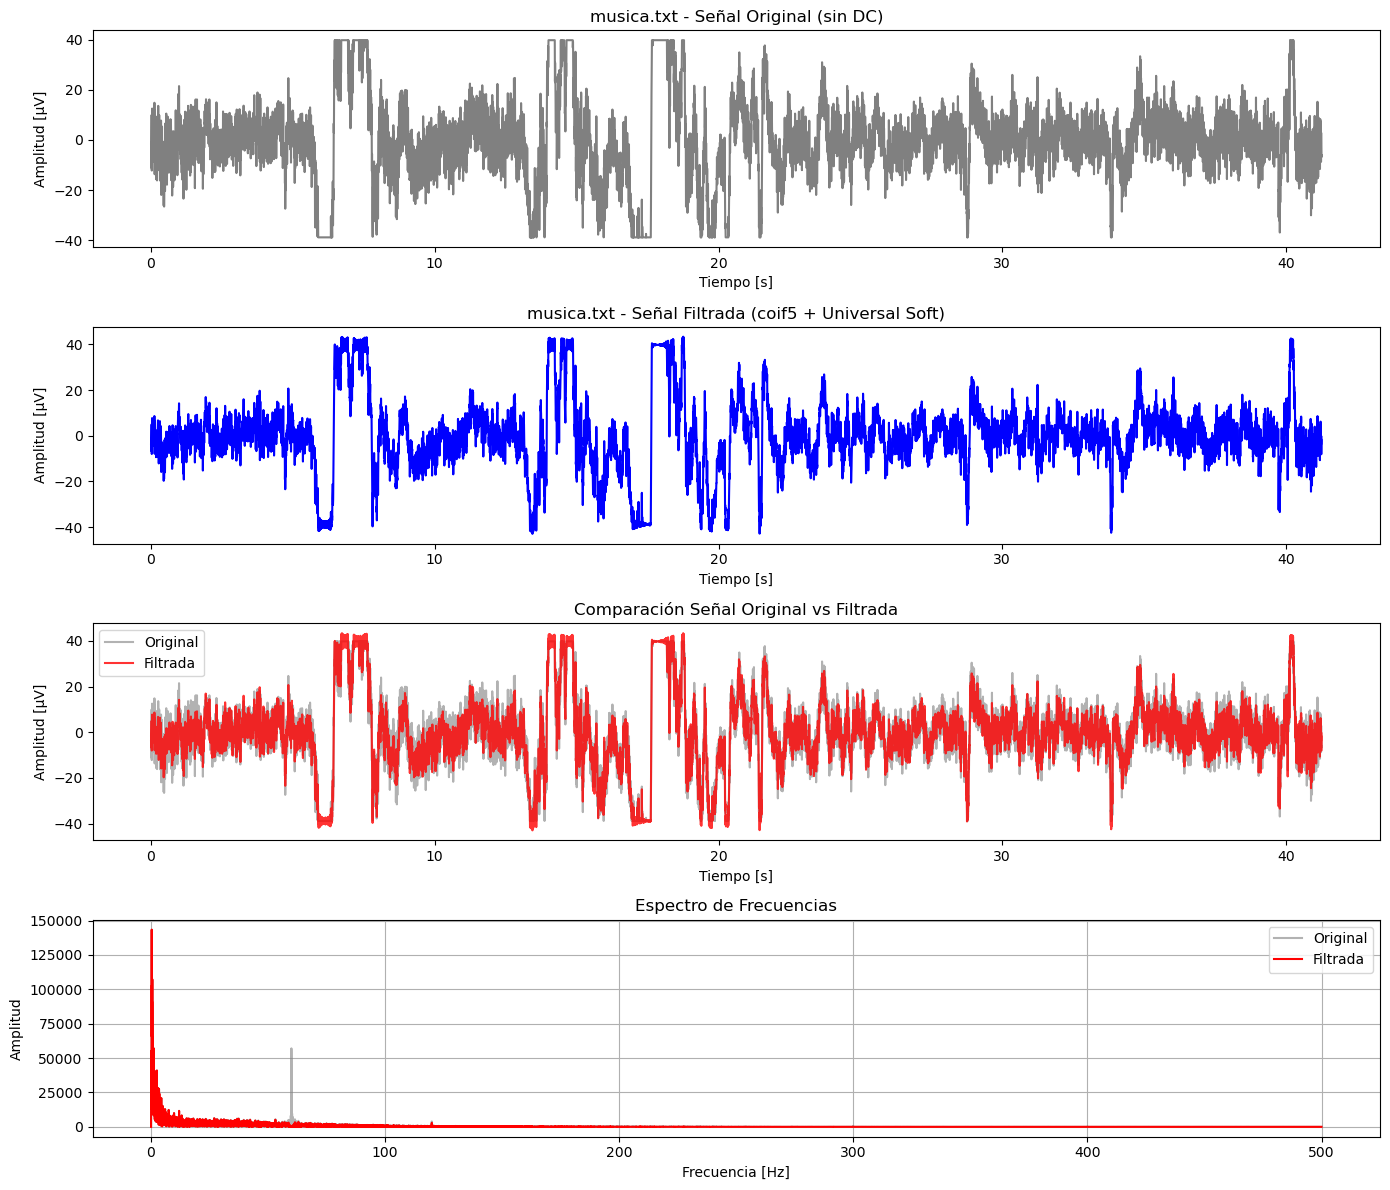

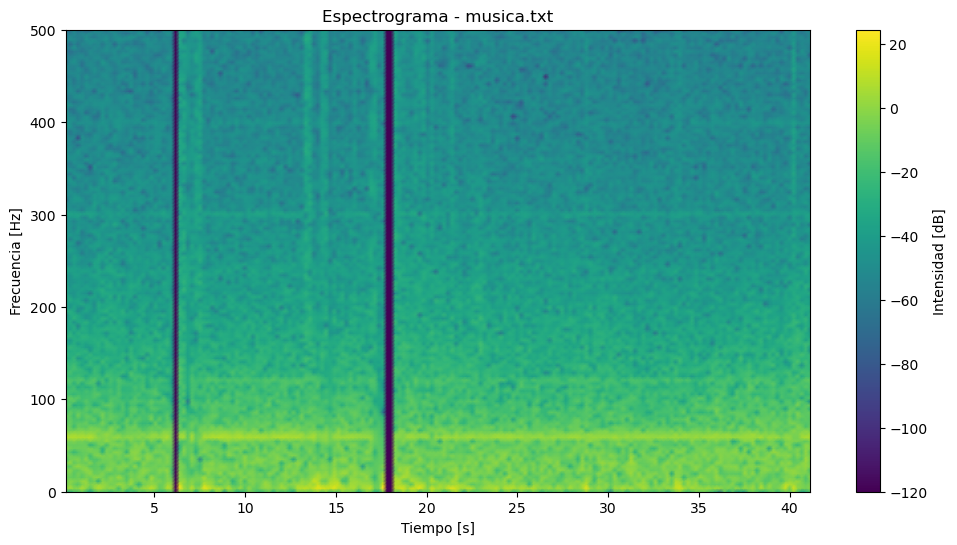

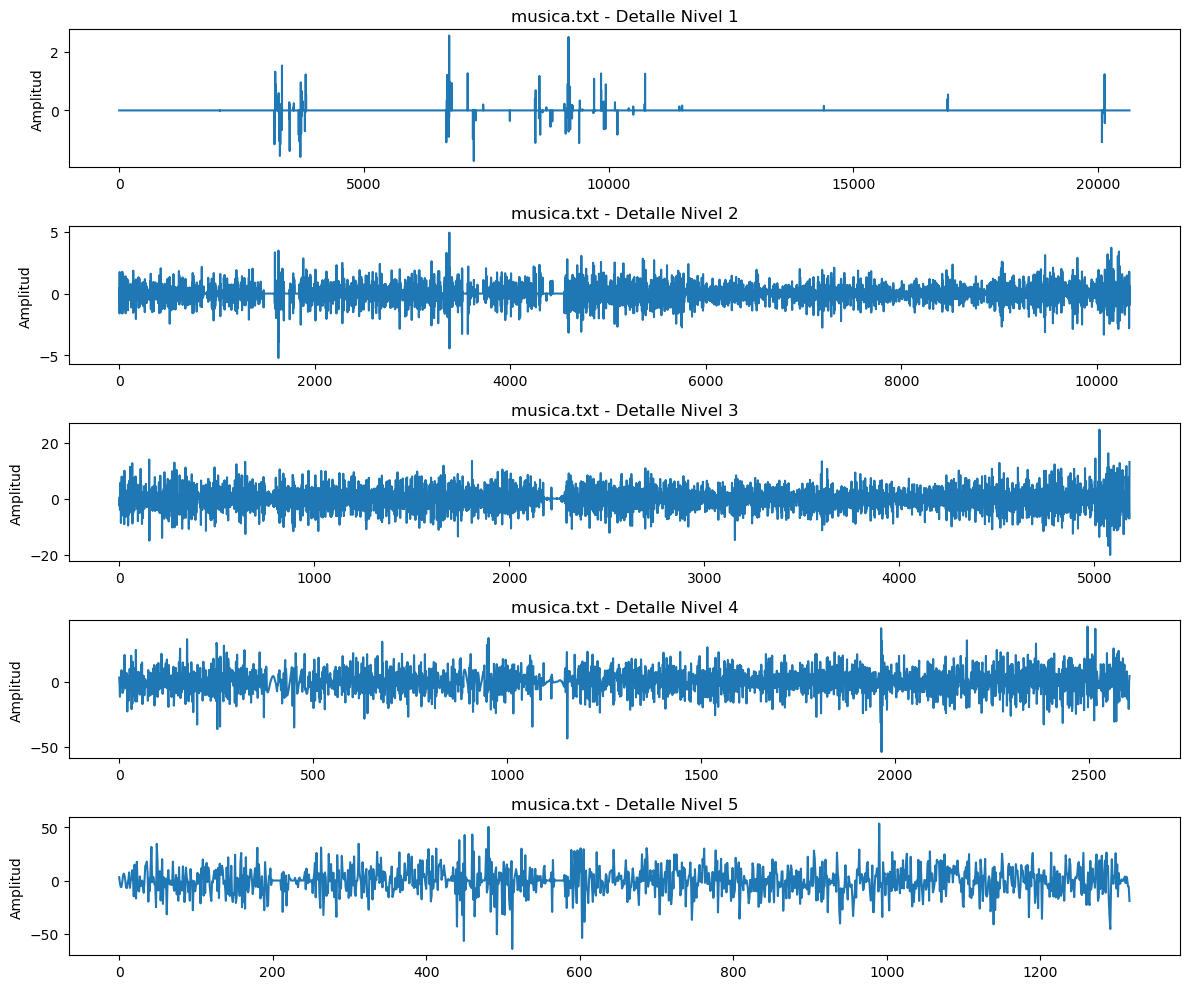

In [4]:
# =============================================================================
# FILTRADO WAVELET PARA MÚLTIPLES SEÑALES EEG - coif5 + Umbral Universal (Soft)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from sklearn.metrics import mean_squared_error
import os

# === 1. Carpeta y lista de archivos ===
carpeta = r"C:\SeñalesLab3\Lab4"
archivos = ["Copilado1EEG.txt", "RestaEEG.txt", "Parpadeo2.txt", "musica.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 41782      # Ganancia EEG
ADCres = 1023
fs = 1000         # Frecuencia de muestreo [Hz]

# === 3. Parámetros Wavelet ===
wavelet = 'coif5'
nivel = 5

# === 4. Filtro Notch (60 Hz) ===
def notch_filter(signal_data, fs, freq=60.0, Q=30.0):
    b, a = signal.iirnotch(freq, Q, fs)
    return signal.filtfilt(b, a, signal_data)

# === 5. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    
    EEG_raw = df["O2"].values
    t = np.arange(len(EEG_raw)) / fs

    # --- Conversión ADC → microvoltios (µV) ---
    Volt = (EEG_raw / ADCres) * VCC
    EEG_uV = (Volt / Gain) * 1e6
    EEG_noDC = EEG_uV - np.mean(EEG_uV)
    
    # --- Filtro Notch (60 Hz) ---
    EEG_notch = notch_filter(EEG_noDC, fs)

    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(EEG_notch, wavelet, level=nivel)
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(EEG_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))

    coef_filtrados = [coeficientes[0]]  # coeficiente de aproximación
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_universal, mode='soft'))

    EEG_filtrada = pywt.waverec(coef_filtrados, wavelet)

    # --- Métricas ---
    mse_val = mean_squared_error(EEG_notch, EEG_filtrada)
    snr_val = 10 * np.log10(np.sum(EEG_notch**2) / np.sum((EEG_notch - EEG_filtrada)**2))

    print(f"\nArchivo: {archivo}")
    print(f"MSE después del filtrado: {mse_val:.4f}")
    print(f"SNR después del filtrado: {snr_val:.2f} dB")

    # === Gráficas ===
    plt.figure(figsize=(14, 12))

    # Señal original (sin DC)
    plt.subplot(4, 1, 1)
    plt.plot(t, EEG_noDC, color='gray')
    plt.title(f"{archivo} - Señal Original (sin DC)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")

    # Señal filtrada
    plt.subplot(4, 1, 2)
    plt.plot(t, EEG_filtrada, color='blue')
    plt.title(f"{archivo} - Señal Filtrada (coif5 + Universal Soft)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")

    # Comparación
    plt.subplot(4, 1, 3)
    plt.plot(t, EEG_noDC, label="Original", color='gray', alpha=0.6)
    plt.plot(t, EEG_filtrada, label="Filtrada", color='red', alpha=0.8)
    plt.title("Comparación Señal Original vs Filtrada")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    plt.legend()

    # Espectro
    plt.subplot(4, 1, 4)
    frecuencias = np.fft.fftfreq(len(EEG_noDC), 1/fs)
    X_original = np.fft.fft(EEG_noDC)
    X_filtrada = np.fft.fft(EEG_filtrada)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_original[:len(frecuencias)//2]), label='Original', color='gray', alpha=0.6)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_filtrada[:len(frecuencias)//2]), label='Filtrada', color='red')
    plt.title("Espectro de Frecuencias")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # --- Espectrograma ---
    f, t_spec, Sxx = signal.spectrogram(EEG_noDC, fs)
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-12), shading='gouraud')  # evita log10(0)
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.title(f'Espectrograma - {archivo}')
    plt.colorbar(label='Intensidad [dB]')
    plt.show()

    # --- Coeficientes de detalle ---
    fig, axs = plt.subplots(nivel, 1, figsize=(12, 10))
    for i in range(nivel):
        axs[i].plot(coef_filtrados[nivel - i])
        axs[i].set_title(f'{archivo} - Detalle Nivel {i+1}')
        axs[i].set_ylabel('Amplitud')
    plt.tight_layout()
    plt.show()





Archivo: Copilado1EEG.txt
MSE después del filtrado: 0.1419
SNR después del filtrado: 22.76 dB


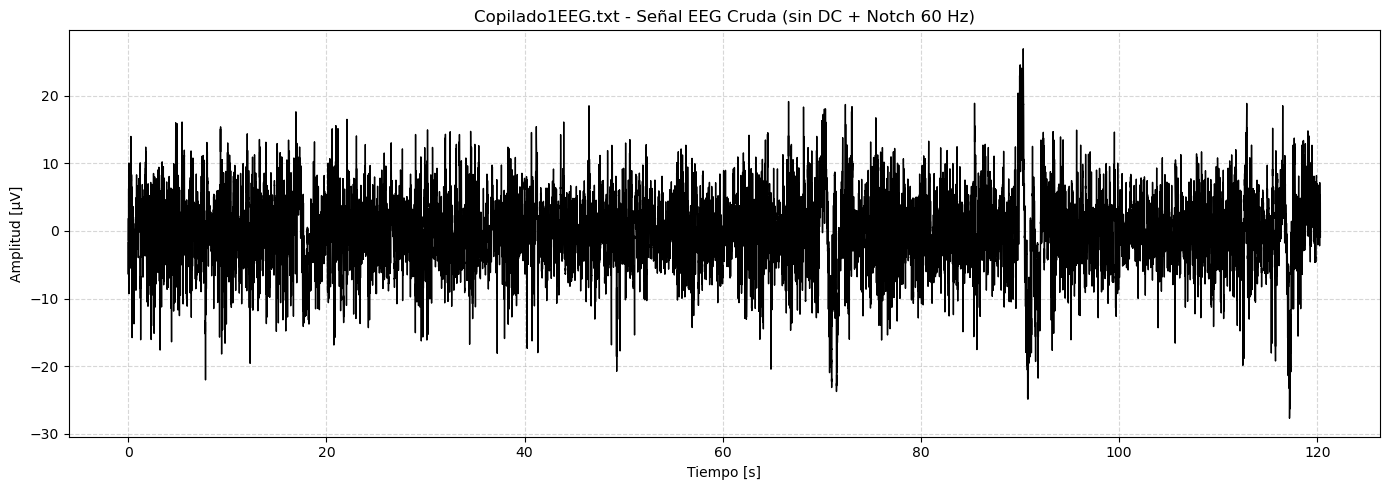

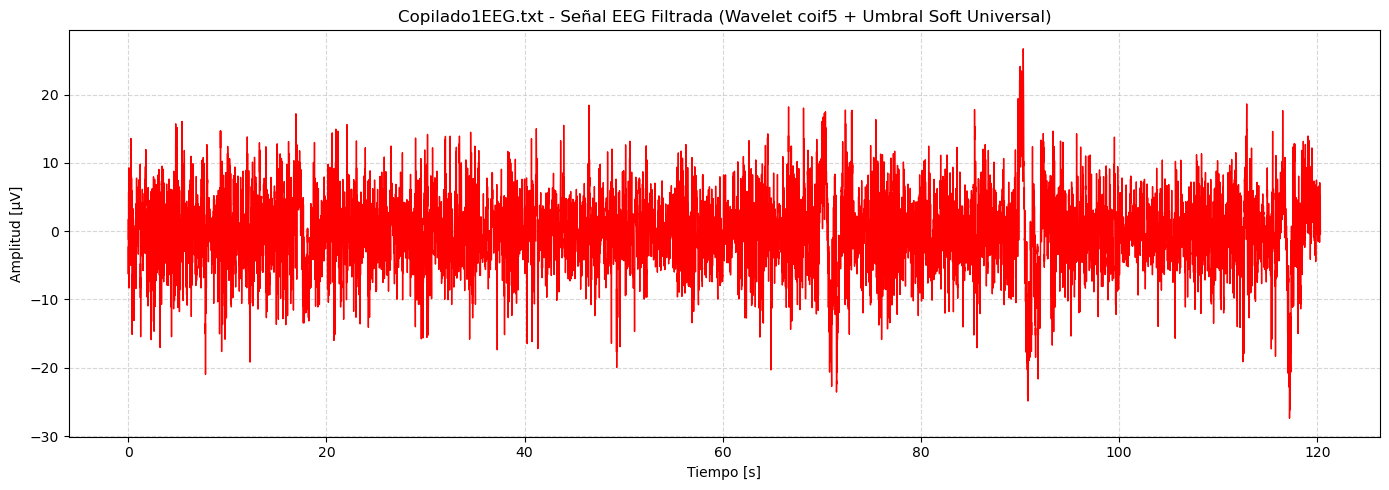


Archivo: RestaEEG.txt
MSE después del filtrado: 0.0930
SNR después del filtrado: 33.74 dB


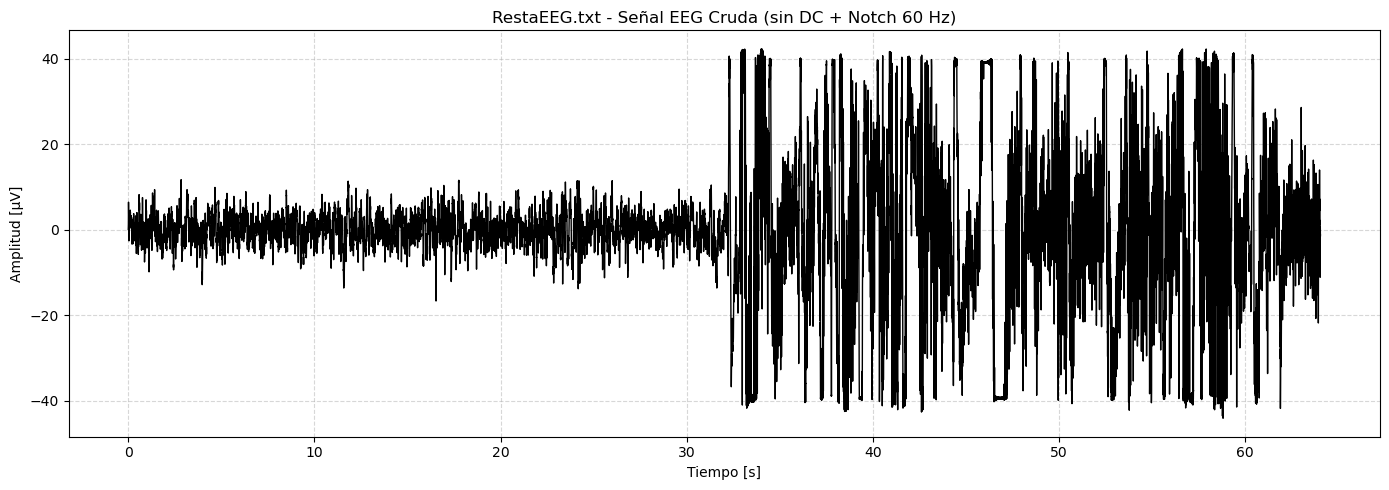

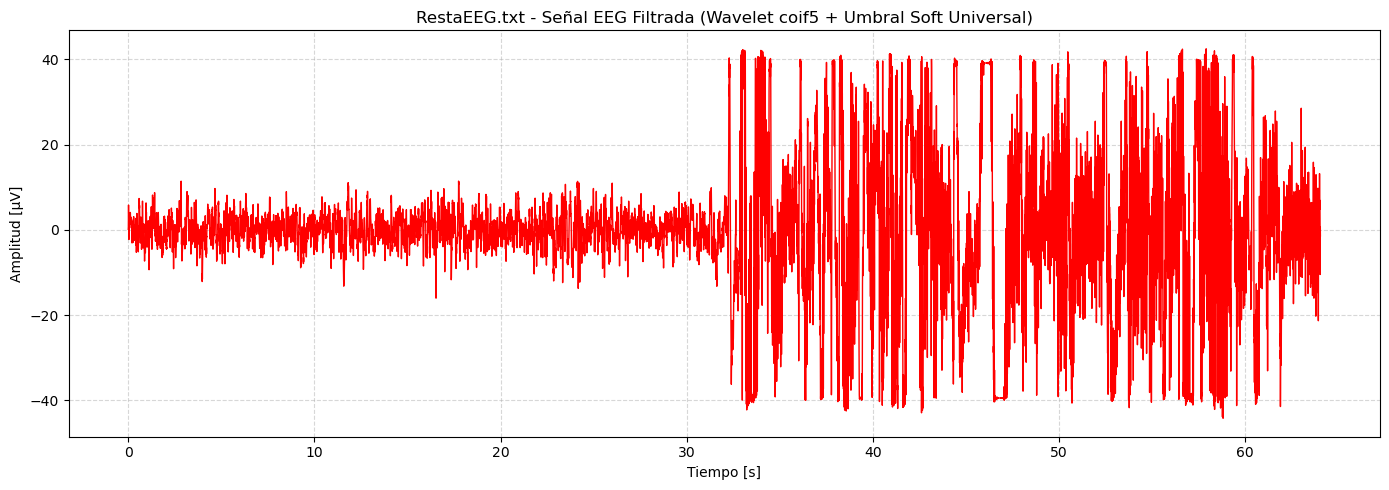


Archivo: Parpadeo2.txt
MSE después del filtrado: 0.1231
SNR después del filtrado: 32.20 dB


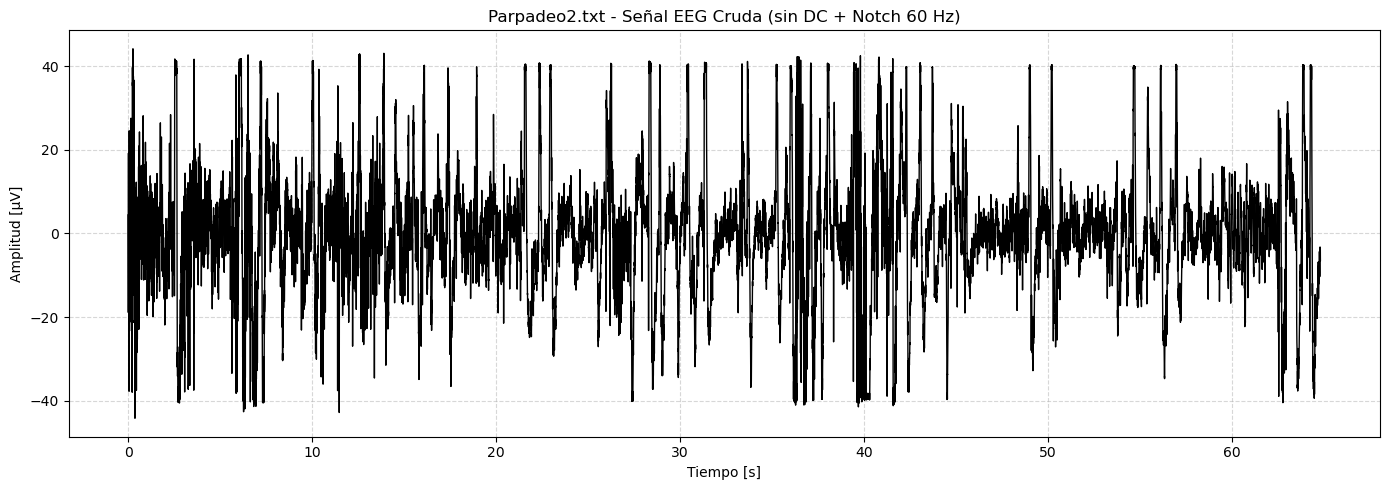

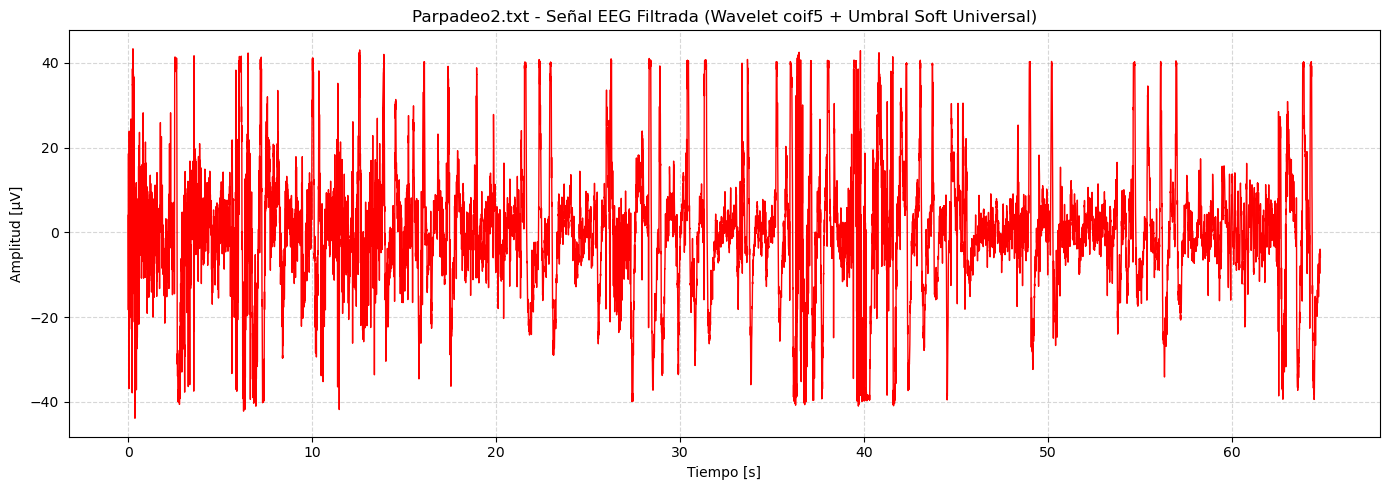


Archivo: musica.txt
MSE después del filtrado: 0.1157
SNR después del filtrado: 33.27 dB


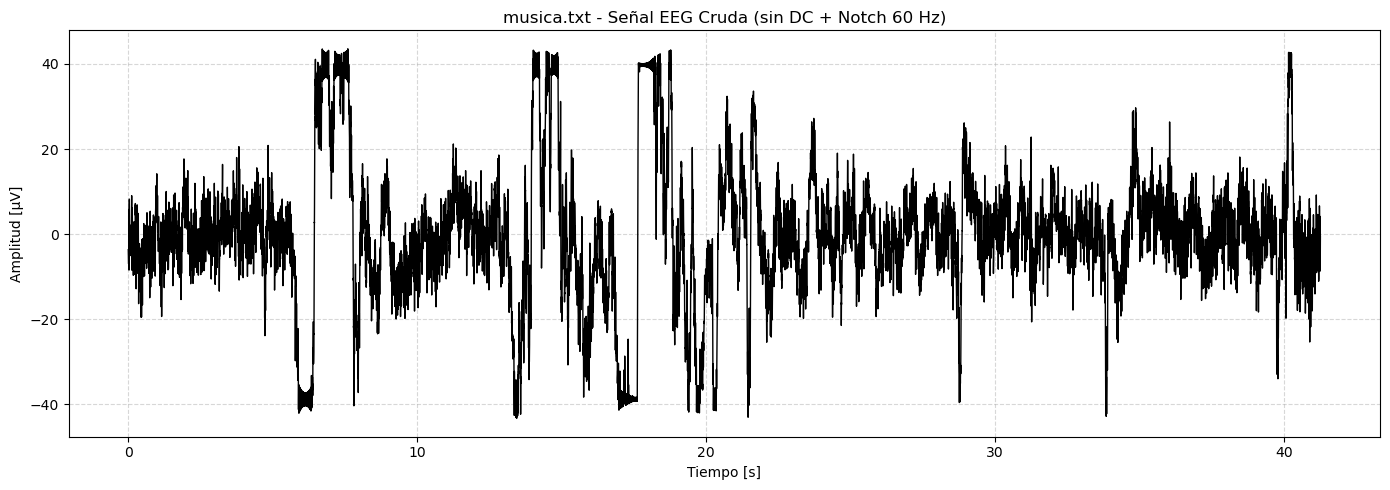

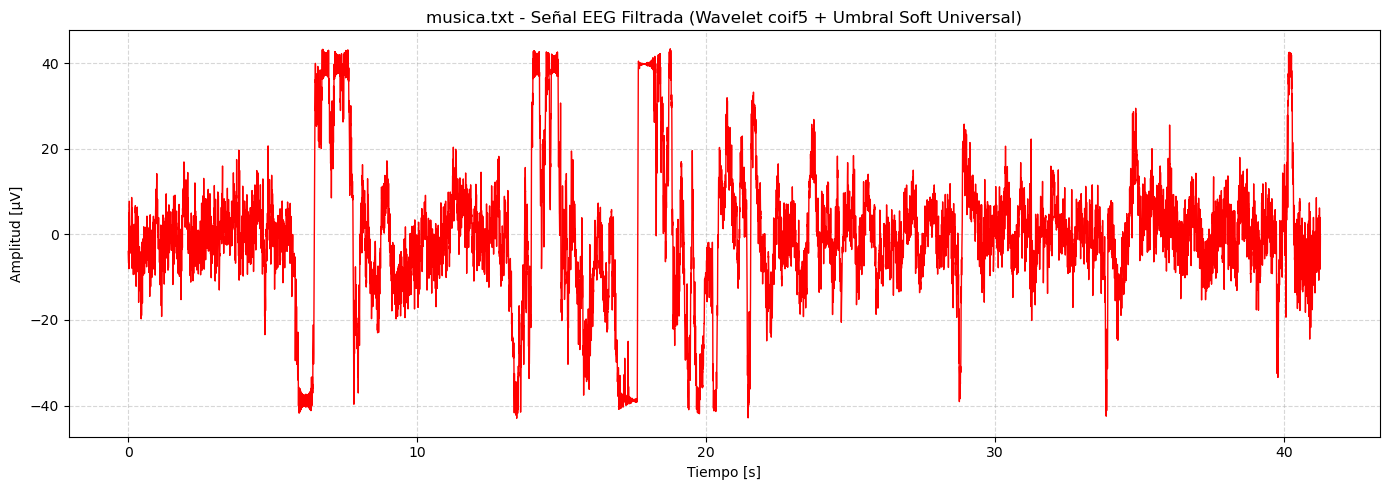

In [6]:
# =============================================================================
# FILTRADO WAVELET PARA MÚLTIPLES SEÑALES EEG - Señal cruda (negra) y filtrada (roja)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from sklearn.metrics import mean_squared_error
import os

# === 1. Carpeta y lista de archivos ===
carpeta = r"C:\SeñalesLab3\Lab4"
archivos = ["Copilado1EEG.txt", "RestaEEG.txt", "Parpadeo2.txt", "musica.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 41782      # Ganancia EEG
ADCres = 1023
fs = 1000         # Frecuencia de muestreo [Hz]

# === 3. Parámetros Wavelet ===
wavelet = 'coif5'
nivel = 5

# === 4. Filtro Notch (60 Hz) ===
def notch_filter(signal_data, fs, freq=60.0, Q=30.0):
    b, a = signal.iirnotch(freq, Q, fs)
    return signal.filtfilt(b, a, signal_data)

# === 5. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    
    EEG_raw = df["O2"].values
    t = np.arange(len(EEG_raw)) / fs

    # --- Conversión ADC → microvoltios (µV) ---
    Volt = (EEG_raw / ADCres) * VCC
    EEG_uV = (Volt / Gain) * 1e6
    EEG_noDC = EEG_uV - np.mean(EEG_uV)
    
    # --- Filtro Notch (60 Hz) ---
    EEG_notch = notch_filter(EEG_noDC, fs)

    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(EEG_notch, wavelet, level=nivel)
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(EEG_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))

    coef_filtrados = [coeficientes[0]]  # coeficiente de aproximación
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_universal, mode='soft'))

    EEG_filtrada = pywt.waverec(coef_filtrados, wavelet)

    # --- Métricas ---
    mse_val = mean_squared_error(EEG_notch, EEG_filtrada)
    snr_val = 10 * np.log10(np.sum(EEG_notch**2) / np.sum((EEG_notch - EEG_filtrada)**2))

    print(f"\nArchivo: {archivo}")
    print(f"MSE después del filtrado: {mse_val:.4f}")
    print(f"SNR después del filtrado: {snr_val:.2f} dB")

    # === FIGURA 1: Señal cruda (negra) ===
    plt.figure(figsize=(14, 5))
    plt.plot(t, EEG_notch, color='black', linewidth=1)
    plt.title(f"{archivo} - Señal EEG Cruda (sin DC + Notch 60 Hz)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === FIGURA 2: Señal filtrada (roja) ===
    plt.figure(figsize=(14, 5))
    plt.plot(t[:len(EEG_filtrada)], EEG_filtrada, color='red', linewidth=1)
    plt.title(f"{archivo} - Señal EEG Filtrada (Wavelet {wavelet} + Umbral Soft Universal)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
